In [1]:
!pip install --quiet -U optuna neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.8/254.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00


In [2]:
import yfinance as yf

# Descargar datos de los 8 tickers
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1d')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%***********************]  8 of 8 completed


In [3]:
horizon = 180

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from neuralforecast import NeuralForecast
from neuralforecast.models import TiDE
from neuralforecast.losses.pytorch import SMAPE
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import smape as smape_cv, mape as mape_cv, mae as mae_cv, mse as mse_cv, rmse as rmse_cv
import logging
import warnings

# Configuraciones para ignorar advertencias
warnings.simplefilter(action='ignore', category=FutureWarning)
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger("lightning_fabric").setLevel(logging.WARNING)

# Función objetivo para cada serie temporal
def objective(trial, df_serie):
    try:
        # Definir los hiperparámetros a optimizar
        hidden_size = trial.suggest_categorical('hidden_size', [256, 512, 1024])
        input_size = trial.suggest_int('input_size', 1, 3)
        num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 3)
        num_decoder_layers = trial.suggest_int('num_decoder_layers', 1, 3)
        decoder_output_dim = trial.suggest_categorical('decoder_output_dim', [4, 8, 16, 32])
        temporal_decoder_dim = trial.suggest_categorical('temporal_decoder_dim', [32, 64, 128])
        dropout = trial.suggest_categorical('dropout', [0.0, 0.1, 0.2, 0.3, 0.5])
        layernorm = trial.suggest_categorical('layernorm', [True, False])
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

        # Crear el modelo TiDE
        model = TiDE(
            h=horizon,
            input_size=input_size,
            hidden_size=hidden_size,
            decoder_output_dim=decoder_output_dim,
            temporal_decoder_dim=temporal_decoder_dim,
            dropout=dropout,
            layernorm=layernorm,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            learning_rate=learning_rate,
            loss=SMAPE(),
            enable_progress_bar=False
        )

        # Crear y ajustar el modelo
        nf = NeuralForecast(models=[model], freq='D')

        # Validación cruzada
        cv_df = nf.cross_validation(df_serie, n_windows=5, step_size=horizon)
        cv_df = cv_df.reset_index()

        # Evaluar las predicciones
        evaluation_df = evaluate(cv_df.loc[:, cv_df.columns != 'cutoff'],
                                 metrics=[smape_cv, mape_cv, mae_cv, mse_cv, rmse_cv])

        smape = evaluation_df[evaluation_df['metric'] == 'smape']['TiDE'].values[0]
        mape = evaluation_df[evaluation_df['metric'] == 'mape']['TiDE'].values[0]
        mae = evaluation_df[evaluation_df['metric'] == 'mae']['TiDE'].values[0]
        mse = evaluation_df[evaluation_df['metric'] == 'mse']['TiDE'].values[0]
        rmse = evaluation_df[evaluation_df['metric'] == 'rmse']['TiDE'].values[0]

        # Guardar métricas en los atributos del trial
        trial.set_user_attr('mape', mape)
        trial.set_user_attr('mae', mae)
        trial.set_user_attr('mse', mse)
        trial.set_user_attr('rmse', rmse)

        return smape
    except Exception as e:
        print(f"Error en el trial para el ticker: {df_serie['unique_id'].unique()[0]}: {e}")
        raise optuna.exceptions.TrialPruned()

In [6]:
best_params_by_ticker = {}

# Iterar sobre cada serie temporal (asegúrate de tener 'tickers' definidos)
for ticker in tickers:
    print(f"Optimizando para {ticker}")

    # Filtrar los datos por ticker
    df_ticker = Y_df[Y_df['unique_id'] == ticker].reset_index(drop=True)

    # Crear el estudio de Optuna para cada ticker
    study = optuna.create_study(direction='minimize')

    # Optimizar los hiperparámetros
    study.optimize(lambda trial: objective(trial, df_ticker), n_trials=25)

    # Si el estudio tiene éxito, se imprimen los mejores resultados
    if study.best_trial:
        best_trial = study.best_trial
        mape = best_trial.user_attrs['mape']
        mae = best_trial.user_attrs['mae']
        mse = best_trial.user_attrs['mse']
        rmse = best_trial.user_attrs['rmse']

        best_params_by_ticker[ticker] = study.best_params

        print("Mejores hiperparámetros:", study.best_params)
        print("Mejor SMAPE:", study.best_value)
        print(f'Best MAPE: {mape}')
        print(f'Best MAE: {mae}')
        print(f'Best MSE: {mse}')
        print(f'Best RMSE: {rmse}')
    else:
        print("No hay trials completados exitosamente.")

Optimizando para AAPL
Mejores hiperparámetros: {'hidden_size': 256, 'input_size': 3, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'decoder_output_dim': 32, 'temporal_decoder_dim': 64, 'dropout': 0.5, 'layernorm': False, 'learning_rate': 0.0032635527000890265}
Mejor SMAPE: 0.055907796294875696
Best MAPE: 0.12218601482874465
Best MAE: 19.068027742173935
Best MSE: 1281.7526546841182
Best RMSE: 35.80157335486973
Optimizando para MSFT
Mejores hiperparámetros: {'hidden_size': 256, 'input_size': 2, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 16, 'temporal_decoder_dim': 64, 'dropout': 0.5, 'layernorm': False, 'learning_rate': 0.001305348353953481}
Mejor SMAPE: 0.09161784244664269
Best MAPE: 0.19876588287906954
Best MAE: 56.638505401611326
Best MSE: 13346.18284927547
Best RMSE: 115.52568047527558
Optimizando para GOOGL
Mejores hiperparámetros: {'hidden_size': 512, 'input_size': 1, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'decoder_output_dim': 8, 'tempor

In [7]:
import time

# Lista para almacenar los resultados de las predicciones
predictions_list = []

# Iterar sobre cada serie temporal
for ticker in Y_df['unique_id'].unique():

    predict_start = time.time()
    print(f"Generando predicción para {ticker}")

    best_params = best_params_by_ticker[ticker]

    # Crear el modelo TiDE con los mejores hiperparámetros
    model_TiDE = TiDE(h=horizon, **best_params, loss=SMAPE(), enable_progress_bar=False)
    nf = NeuralForecast(models=[model_TiDE], freq='D')

    # Filtrar los datos por ticker
    df_ticker = Y_df[Y_df['unique_id'] == ticker].reset_index(drop=True)

    # Separar los datos en entrenamiento y prueba
    prediction_length = len(df_ticker) - horizon
    Y_df_real = df_ticker.iloc[:prediction_length].copy()
    Y_df_test = df_ticker.iloc[prediction_length:].copy()

    # Ajustar el modelo con los datos de entrenamiento
    nf.fit(Y_df_real)

    # Realizar la predicción
    forecast_df = nf.predict(Y_df_real)
    predict_end = time.time()

    # Calcular el tiempo de predicción
    predict_time = predict_end - predict_start
    print(f"Tiempo de predicción: {predict_time:.2f} segundos")

    # Agregar ticker a las predicciones
    forecast_df['unique_id'] = ticker
    predictions_list.append(forecast_df)

# Concatenar todas las predicciones en un solo DataFrame
all_forecast_df = pd.concat(predictions_list)

Generando predicción para AAPL
Tiempo de predicción: 18.54 segundos
Generando predicción para AMZN
Tiempo de predicción: 11.89 segundos
Generando predicción para BTC-USD
Tiempo de predicción: 17.72 segundos
Generando predicción para GOOGL
Tiempo de predicción: 18.55 segundos
Generando predicción para IBM
Tiempo de predicción: 14.80 segundos
Generando predicción para META
Tiempo de predicción: 20.76 segundos
Generando predicción para MSFT
Tiempo de predicción: 14.97 segundos
Generando predicción para NVDA
Tiempo de predicción: 18.54 segundos


In [8]:
all_forecast_df

,ds,TiDE,unique_id
unique_id,,,
AAPL,2024-01-17 00:00:00+00:00,180.239273,AAPL
AAPL,2024-01-18 00:00:00+00:00,183.457397,AAPL
AAPL,2024-01-19 00:00:00+00:00,183.638855,AAPL
AAPL,2024-01-20 00:00:00+00:00,181.845078,AAPL
AAPL,2024-01-21 00:00:00+00:00,182.263794,AAPL
...,...,...,...
NVDA,2024-07-10 00:00:00+00:00,31.167564,NVDA
NVDA,2024-07-11 00:00:00+00:00,31.978386,NVDA
NVDA,2024-07-12 00:00:00+00:00,28.920475,NVDA


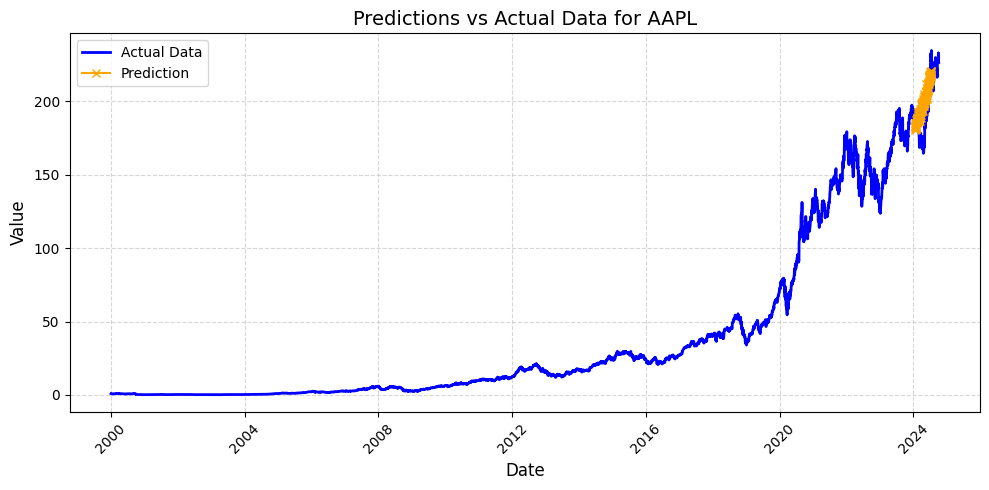

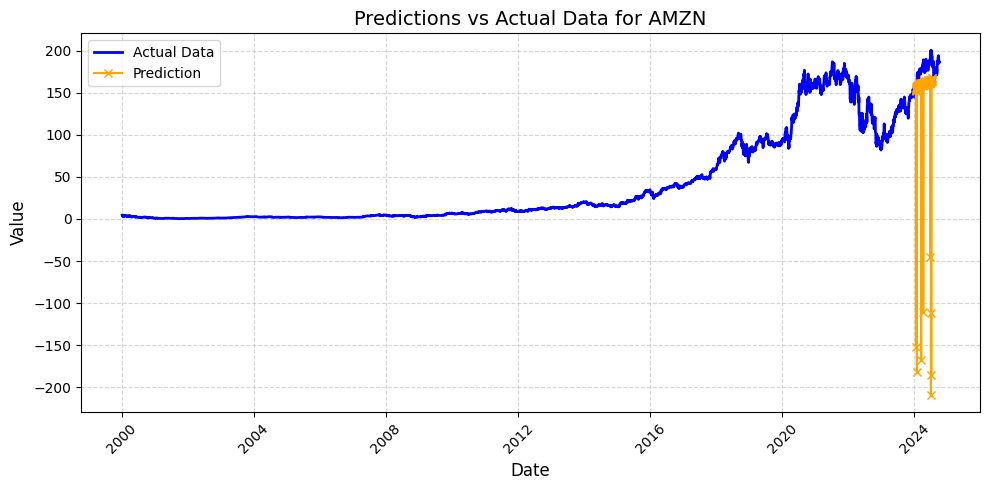

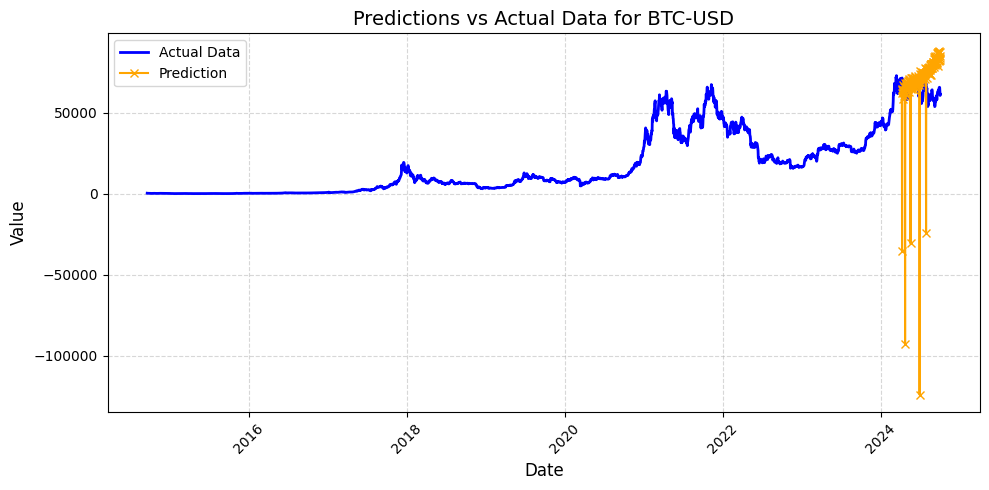

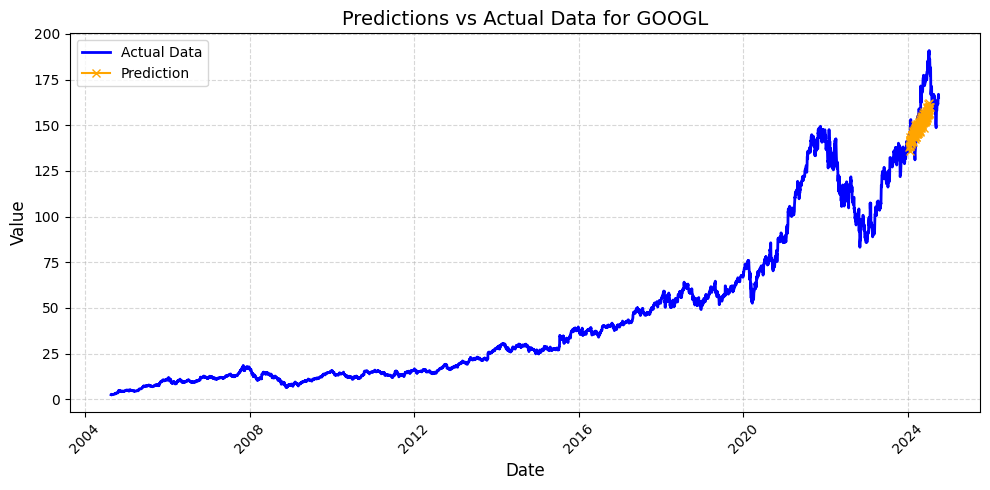

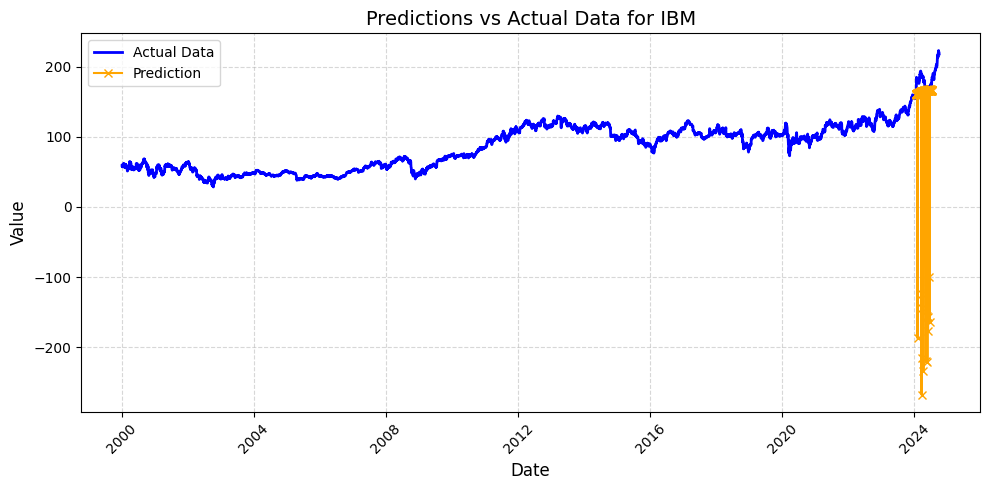

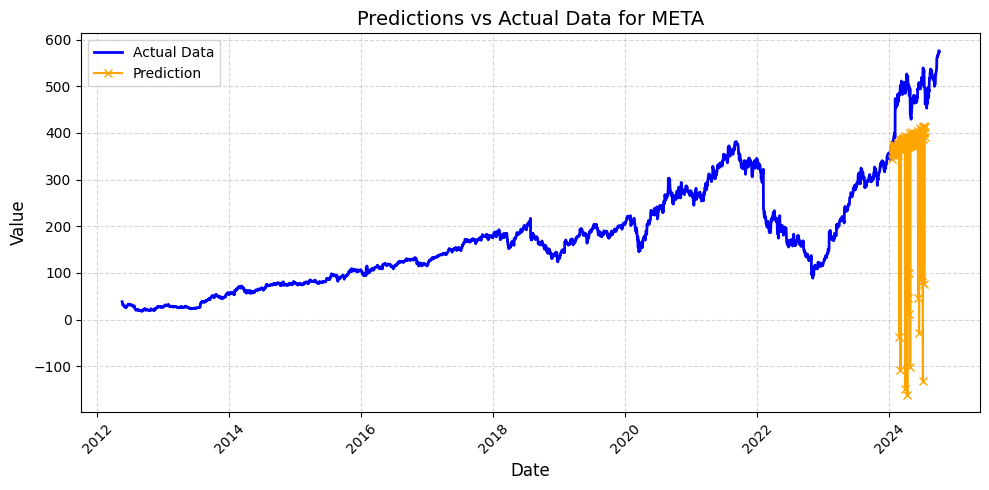

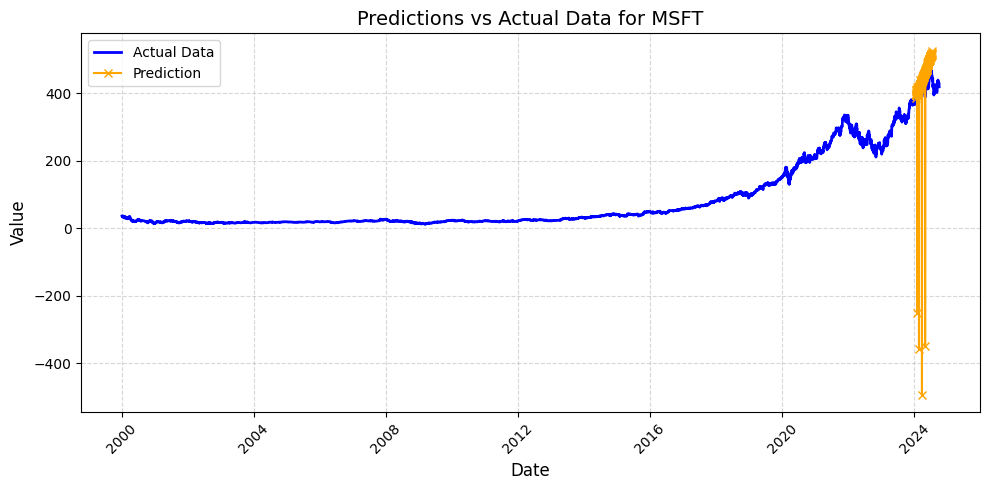

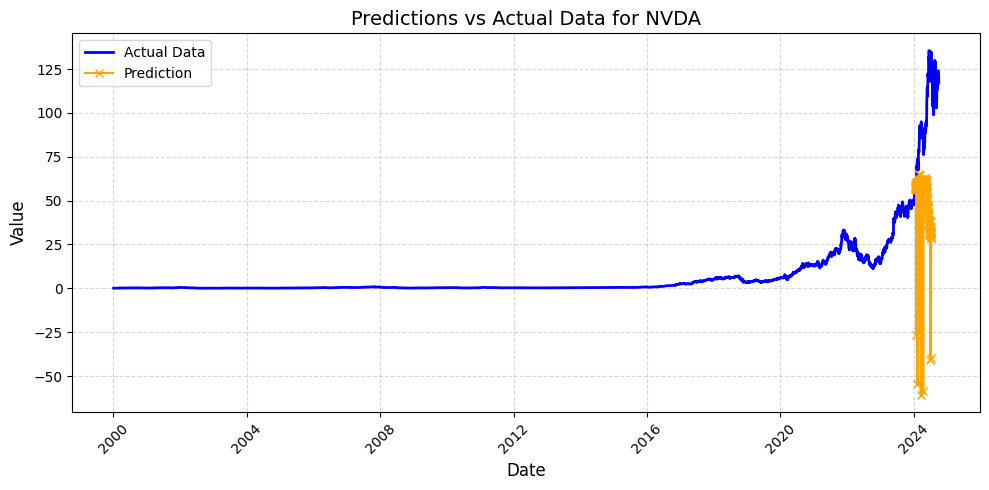

In [9]:
# Plotting predictions for each time series
for ticker in all_forecast_df['unique_id'].unique():
    plt.figure(figsize=(10, 5))

    # Filter predictions and actual data by ticker
    forecast_data = all_forecast_df[all_forecast_df['unique_id'] == ticker]
    actual_data = Y_df[Y_df['unique_id'] == ticker]

    # Plot actual data as a solid line
    plt.plot(actual_data['ds'], actual_data['y'], label='Actual Data', linestyle='-', color='blue', linewidth=2)

    # Plot predictions as a dashed line
    plt.plot(forecast_data['ds'], forecast_data['TiDE'], label='Prediction', marker='x', color='orange')

    # Configure the plot
    plt.title(f'Predictions vs Actual Data for {ticker}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(visible=True, linestyle='--', alpha=0.5)

    # Show the plot
    plt.show()